In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)

In [101]:
df = pd.read_csv('../datos/datos_limpios.csv')

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025721 entries, 0 to 1025720
Data columns (total 16 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   codigo_org_sup              1025721 non-null  int64  
 1   nombre_org_sup              1025721 non-null  object 
 2   codigo_org                  1025721 non-null  int64  
 3   nombre_org                  1025721 non-null  object 
 4   codigo_unidad_gestora       1025721 non-null  int64  
 5   nombre_unidad_gestora       1025721 non-null  object 
 6   categoria_economica         1025721 non-null  object 
 7   origen_ingreso              1025721 non-null  object 
 8   especie_ingreso             1025721 non-null  object 
 9   detalle_ingreso             1025721 non-null  object 
 10  valor_previsto_actualizado  1025721 non-null  float64
 11  valor_lanzado               1025721 non-null  float64
 12  valor_recaudado             1025721 non-null  float64
 1

# 0.1 Análisis inicial exploratorio de datos

In [103]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
codigo_org_sup,"1,025,721.00","32,053.63","10,614.19","20,000.00","25,000.00","26,000.00","39,000.00","81,000.00"
codigo_org,"1,025,721.00","31,438.19","10,384.49","20,101.00","25,201.00","26,298.00","36,000.00","91,214.00"
codigo_unidad_gestora,"1,025,721.00","231,320.81","144,211.27","110,005.00","154,003.00","170,013.00","250,088.00","913,001.00"
valor_previsto_actualizado,"1,025,721.00","27,626,980.25","3,394,323,069.57","-214,773,743.00",0.00,0.00,0.00,"1,603,521,711,208.00"
valor_lanzado,"1,025,721.00","2,712,342.56","698,431,477.24","-148,347,267,246.91",0.00,0.00,0.00,"357,160,677,863.97"
valor_recaudado,"1,025,721.00","24,994,498.93","1,407,288,764.63","-156,285,934,188.03",262.50,"3,030.00","40,932.50","771,117,711,060.95"
porcentaje_recaudado,"1,025,721.00",80.36,"71,501.25","-114,552.00",0.00,0.00,0.00,"72,363,772.00"
fecha_anual,"1,025,721.00","2,018.23",1.74,"2,013.00","2,017.00","2,018.00","2,020.00","2,021.00"


# 0.1.2 Insights
- Las columnas  `valor_lanzado`, `porcentaje_recaudado`, `valor_recaudado`, `valor_previsto_actualizado` cuentan con valores negativos significativos.
- Presencia de ceros, sugiere datos faltantes.

In [104]:
df.nunique()

codigo_org_sup                    25
nombre_org_sup                    25
codigo_org                       291
nombre_org                       287
codigo_unidad_gestora            364
nombre_unidad_gestora            356
categoria_economica                5
origen_ingreso                    15
especie_ingreso                   63
detalle_ingreso                 1886
valor_previsto_actualizado     18588
valor_lanzado                   6351
valor_recaudado               605783
porcentaje_recaudado             971
fecha_ingreso                   2157
fecha_anual                        9
dtype: int64

In [105]:
df.quantile([0.1, 0.25, 0.5, 0.75, 0.9], numeric_only=True)

,codigo_org_sup,codigo_org,codigo_unidad_gestora,valor_previsto_actualizado,valor_lanzado,valor_recaudado,porcentaje_recaudado,fecha_anual
0.10,"25,000.00","22,211.00","135,100.00",0.00,0.00,25.00,0.00,"2,016.00"
0.25,"25,000.00","25,201.00","154,003.00",0.00,0.00,262.50,0.00,"2,017.00"
0.50,"26,000.00","26,298.00","170,013.00",0.00,0.00,"3,030.00",0.00,"2,018.00"
0.75,"39,000.00","36,000.00","250,088.00",0.00,0.00,"40,932.50",0.00,"2,020.00"
0.90,"52,000.00","52,132.00","413,047.00",0.00,0.00,"500,592.40",0.00,"2,021.00"


# 0.2 Análisis outliers columnas numéricas

Para ello usaremos [método IQR](https://medium.com/@martacasdelg/c%C3%B3mo-identificar-y-tratar-outliers-con-python-bf7dd530fc3), dónde tomaremos todos aquellos datos por debajo del primer cuartil y por encima del tercero como outliers.
Con esta medición usaremos una medida estandar para tener una primera aproximación sobre cómo se distribuyen estos datos. 


In [110]:
# Creamos un boxplot para variables numéricas
var_num = df.select_dtypes(include=['int64', 'float64']).columns

# Calculamos los rangos intercuartílicos y los límites para outliers
for columna in var_num:
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    
    outliers = ((df[columna] < limite_inferior) | (df[columna] > limite_superior)).sum()
    
    print(f"\nColumna: {columna}")
    print(f"Número de outliers: {outliers}")
    print(f"Porcentaje de outliers: {(outliers/len(df)*100):.2f}%")


Columna: codigo_org_sup
Número de outliers: 5056
Porcentaje de outliers: 0.49%

Columna: codigo_org
Número de outliers: 85420
Porcentaje de outliers: 8.33%

Columna: codigo_unidad_gestora
Número de outliers: 128371
Porcentaje de outliers: 12.52%

Columna: valor_previsto_actualizado
Número de outliers: 19840
Porcentaje de outliers: 1.93%

Columna: valor_lanzado
Número de outliers: 6640
Porcentaje de outliers: 0.65%

Columna: valor_recaudado
Número de outliers: 193532
Porcentaje de outliers: 18.87%

Columna: porcentaje_recaudado
Número de outliers: 7491
Porcentaje de outliers: 0.73%

Columna: fecha_anual
Número de outliers: 0
Porcentaje de outliers: 0.00%


# 0.2.2 Insights
- El valor más preocupante sería la columna `valor_recaudado` (18.87%), que sugiere una significativa imprevisibilidad en la recaudación de ingresos..

# 0.2.3 Visualización

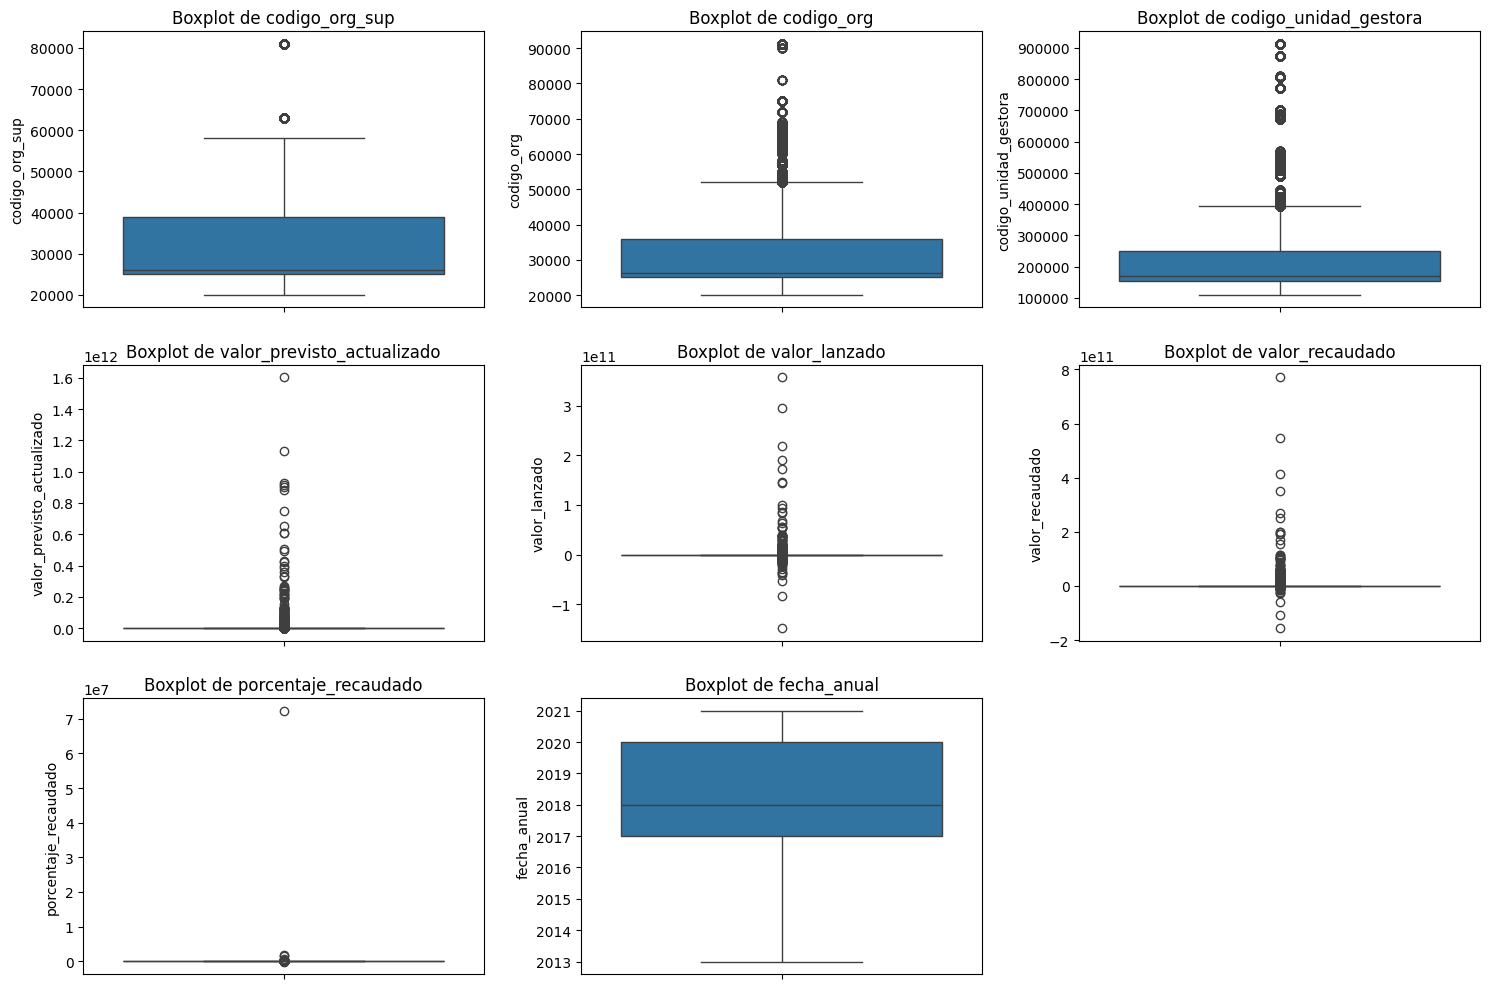

In [111]:
plt.figure(figsize=(15, 10))

for i, columna in enumerate(var_num, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[columna])
    plt.title(f'Boxplot de {columna}')
    
plt.tight_layout()

# 1.1 Análisis de distribución de ingresos por categoría económica

In [ ]:
# Agrupamos por categoria_economica y calculamos los sumatorios de ingresos previstos e ingresos recaudados
analisis_categorias = df.groupby('categoria_economica').agg({
    'valor_recaudado': 'sum',
    'valor_previsto_actualizado': 'sum'
}).round(2)

# Calculamos el porcentaje que suponen en el total recaudado
total_recaudado = analisis_categorias['valor_recaudado'].sum()
analisis_categorias['porcentaje_participacion'] = (analisis_categorias['valor_recaudado'] / total_recaudado * 100).round(2)

analisis_categorias

,valor_recaudado,valor_previsto_actualizado,porcentaje_participacion
categoria_economica,,,
Receitas Correntes,"12,909,343,128,909.43","13,549,526,943,206.14",50.35
Receitas Correntes - intra-orçamentárias,"292,651,790,699.89","291,485,025,919.00",1.14
Receitas de Capital,"12,407,136,680,065.79","14,485,753,431,206.59",48.39
Receitas de Capital - intra-orçamentárias,"28,250,835,724.33","10,808,411,537.00",0.11
Sem informação,46.57,0.00,0.00


# 1.2 Insights
## Concentración de los inresos por categoría económica
Podemos ver que los ingresos se concentran en 2 categorías: `Receita de Capital` y `Receite Corriente`, sumando estos cerca de un 90% de los ingresos. 

Para ayudar con la comprensión, esta es la traducción de las categorías:
- Ingresos Corrientes
- Ingresos Corrientes - intra-presupuestarios
- Ingresos de Capital
- Ingresos de Capital - intra-presupuestarios
- Sin información

Los términos "intra-presupuestarios" se refieren a transacciones que ocurren entre diferentes entidades dentro del mismo presupuesto gubernamental.

# 1.3 Visualización

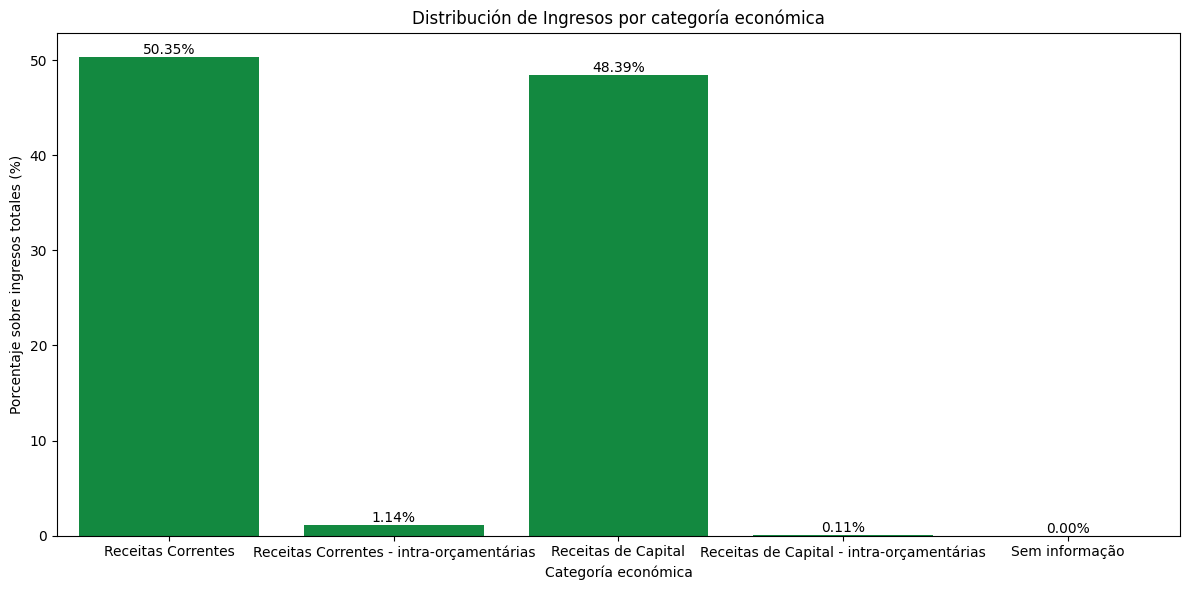

In [53]:

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=analisis_categorias.reset_index(), 
                 x='categoria_economica', 
                 y='porcentaje_participacion',
                 color='#009c3b')

# Para añadir el porcentaje sobre cada barra
for i, v in enumerate(analisis_categorias['porcentaje_participacion']):
    ax.text(i, v, f'{v:.2f}%', 
            ha='center',
            va='bottom')

plt.title('Distribución de Ingresos por categoría económica')
plt.xlabel('Categoría económica')
plt.ylabel('Porcentaje sobre ingresos totales (%)')

plt.tight_layout()

# 2.1 Evolución ingresos por año
- ## 2.1.1 Total ingresos
- ## 2.1.2 Crecimiento interanual
- ## 2.1.3 Estadísticas descriptivas
- ## 2.1.4 Categoría dominante


In [66]:
# 1. Total de ingresos por año
ingresos_anuales = df.groupby('fecha_anual')['valor_recaudado'].sum().round(2)

# 2. Crecimiento interanual
crecimiento_anual = ingresos_anuales.pct_change() * 100

# 3. Estadísticas descriptivas por año
estadisticas_anuales = df.groupby('fecha_anual')['valor_recaudado'].agg([
    ('Sumatorio', 'sum'),
    ('Media', 'mean')
]).round(2)

# 4. Valor máximo por categoría y año
maximos_categoria = df.groupby(['fecha_anual', 'categoria_economica'])['valor_recaudado'].sum().round(2)
categoria_dominante = maximos_categoria.unstack().idxmax(axis=1)

print("1. Total de ingresos por año:")
print(ingresos_anuales)

print("\n2. Crecimiento interanual (%):")
print(crecimiento_anual.round(2))

print("\n3. Estadísticas por año:")
print(estadisticas_anuales)

print("\n4. Categoría con mayor recaudación por año:")
print(categoria_dominante)

1. Total de ingresos por año:
fecha_anual
2013   1,893,613,719,099.78
2014   2,238,551,079,327.88
2015   2,665,685,375,159.13
2016   2,839,711,583,462.82
2017   2,558,047,412,866.96
2018   2,942,387,872,873.97
2019   2,991,564,738,258.26
2020   3,631,448,629,524.17
2021   3,876,372,024,873.04
Name: valor_recaudado, dtype: float64

2. Crecimiento interanual (%):
fecha_anual
2013     NaN
2014   18.22
2015   19.08
2016    6.53
2017   -9.92
2018   15.02
2019    1.67
2020   21.39
2021    6.74
Name: valor_recaudado, dtype: float64

3. Estadísticas por año:
                       Sumatorio          Media
fecha_anual                                    
2013        1,893,613,719,099.78 420,990,155.42
2014        2,238,551,079,327.88 491,665,073.43
2015        2,665,685,375,159.13 589,362,231.96
2016        2,839,711,583,462.82  14,603,738.65
2017        2,558,047,412,866.96  13,435,616.92
2018        2,942,387,872,873.97  16,926,910.20
2019        2,991,564,738,258.26  16,926,167.74
2020       

# 2.2 Insights

## Evolución Total de Ingresos:
- Se observa una tendencia general al alza desde 2013 (1.89T) hasta 2021 (3.88T)
- El crecimiento fue continuo excepto en 2017, donde hubo una caída
- Los mayores niveles se alcanzaron en los últimos dos años (2020 y 2021)
- En 8 años los ingresos se duplicaron aproximadamente


## Crecimiento Interanual:
- Mayor crecimiento: 2020 (21.39%)
- Único crecimiento negativo: 2017 (-9.92%)
- Períodos de fuerte crecimiento: 2014-2015 (~18-19%)
- Períodos de crecimiento moderado: 2016 y 2021 (~6.5%)
- 2019 muestra el crecimiento más bajo positivo (1.67%)


## Estadísticas por Año:
- Los promedios más altos se dieron en 2013-2015
- Los valores máximos más significativos fueron en 2015 (771T)
- Los valores mínimos negativos más pronunciados se dieron en 2016 (-156T)
- Se observa una volatilidad considerable en los valores máximos y mínimos


## Categoría Dominante:
- Alternan el dominio entre Receitas Correntes y Receitas de Capital

# Conclusiones Clave:
- La tendencia general es de crecimiento, con un único año de retroceso (2017)
- Hay una clara alternancia entre ingresos corrientes y de capital como categoría dominante
- Los últimos años (2020-2021) muestran los mayores niveles de ingresos totales
- La volatilidad en máximos y mínimos sugiere fluctuaciones importantes en algunas categorías específicas

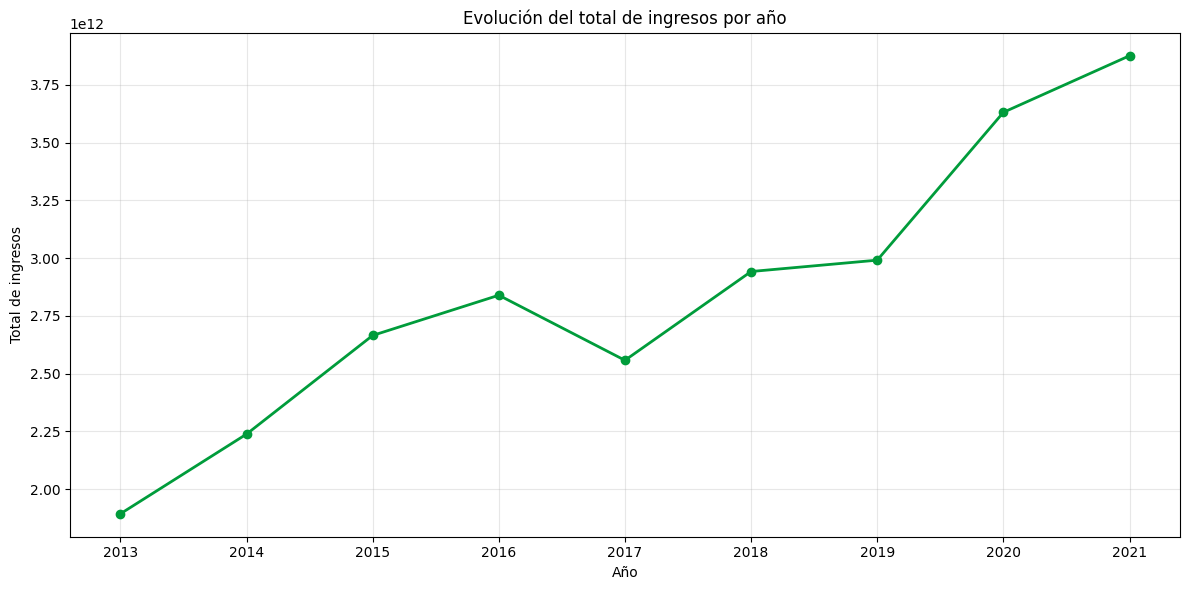

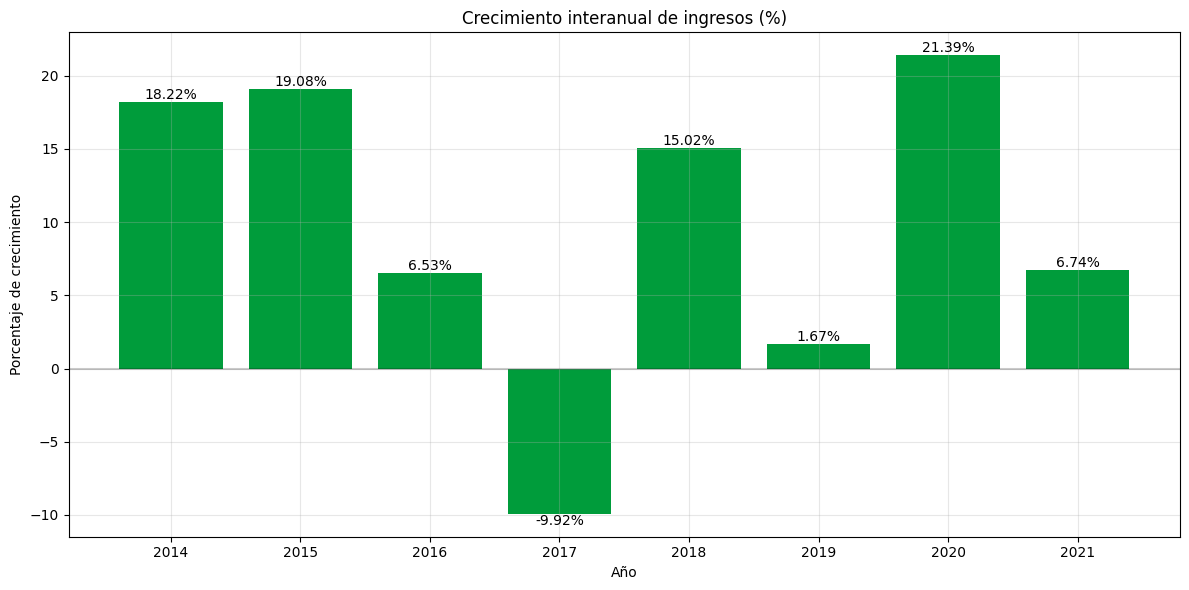

In [ ]:
# 1. Gráfico de línea para mostrar la evolución de los ingresos anuales
plt.figure(figsize=(12, 6))
plt.plot(ingresos_anuales.index, ingresos_anuales.values, marker='o', color='#009c3b', linewidth=2)

plt.title('Evolución del total de ingresos por año')
plt.xlabel('Año')
plt.ylabel('Total de ingresos')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Gráfico de barras con el crecimiento interanual
plt.figure(figsize=(12, 6))
barras = plt.bar(crecimiento_anual.index, crecimiento_anual.values, color='#009c3b')

# Añadimos las etiquetas de porcentaje sobre las barras
for i, v in enumerate(crecimiento_anual):
    if not np.isnan(v):  # Evitamos el primer año que será NaN, al no poder comprar con ningún año anterior
        plt.text(crecimiento_anual.index[i], v, f'{v:,.2f}%', 
                ha='center', va='bottom' if v > 0 else 'top')

plt.title('Crecimiento interanual de ingresos (%)')
plt.xlabel('Año')
plt.ylabel('Porcentaje de crecimiento')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.2)  # Línea en 0%
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3.1 Evolución participación categorías económicas por año

In [ ]:
# Agrupamos por año y categoría, sumando el valor recaudado
analisis_categorias_anual = df.groupby(['fecha_anual', 'categoria_economica'])['valor_recaudado'].sum().round(2)

# Convertimos a DataFrame y calculamos el porcentaje por año
categorias_df = analisis_categorias_anual.unstack()

porcentajes_categorias = categorias_df.apply(lambda x: (x / x.sum() * 100).round(2))

if 'Sem informação' in porcentajes_categorias.columns:
    porcentajes_categorias = porcentajes_categorias.drop('Sem informação', axis=1)

# Mostramos los resultados
print("Distribución porcentual por categoría económica y año:")
print(porcentajes_categorias)

Distribución porcentual por categoría económica y año:
categoria_economica  Receitas Correntes  \
fecha_anual                               
2013                               9.49   
2014                               9.67   
2015                               9.96   
2016                              10.56   
2017                              10.82   
2018                              11.91   
2019                              13.10   
2020                              11.26   
2021                              13.23   

categoria_economica  Receitas Correntes - intra-orçamentárias  \
fecha_anual                                                     
2013                                                     8.18   
2014                                                    11.79   
2015                                                    14.77   
2016                                                    12.33   
2017                                                    11.65   
2018            

# 3.2 Insights

1. **Cambios más significativos**:
   - `Receitas de Capital` triplicó su participación (de 5.18% a 17.30%)
   - `Receitas Capital - intra-orçamentárias` tuvo una caída drástica desde su pico de 25.91% en 2017 hasta 1.59% en 2021

2. **Tendencias clave**:
   - `Receitas Correntes muestra` crecimiento estable y consistente (9.49% a 13.23%)
   - Las categorías `intra-orçamentárias` muestran mayor volatilidad que las regulares
   - 2017-2018 marca un punto de inflexión con cambios estructurales importantes


# 3.3 Visualización:

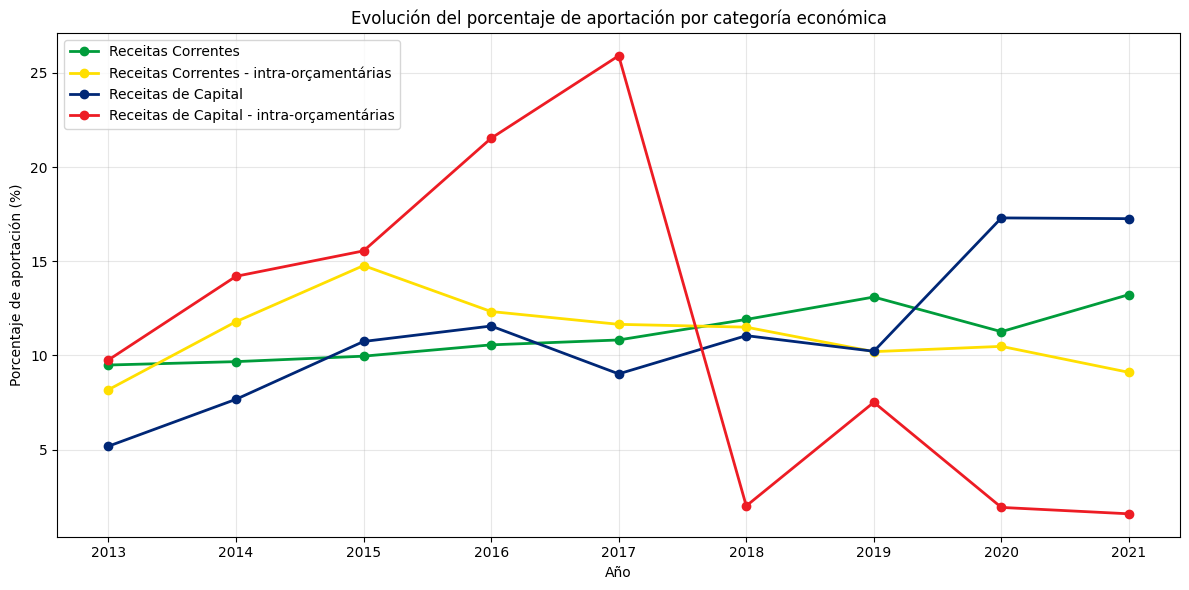

In [ ]:
# Usamos un gráfico de líneas
plt.figure(figsize=(12, 6))
colores = ['#009c3b', '#ffdf00', '#002776', '#ed1c24'] 
for i, columna in enumerate(porcentajes_categorias.columns):
    plt.plot(porcentajes_categorias.index, porcentajes_categorias[columna], 
             marker='o', label=columna, color=colores[i], linewidth=2)
    
plt.title('Evolución del porcentaje de aportación por categoría económica')
plt.xlabel('Año')
plt.ylabel('Porcentaje de aportación (%)')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



# 4.1 Evolución anual entre ingresos previstos y realizados 


In [ ]:
# Agrupamos por año, sumando los valores previstos y realizados
analisis_anual = df.groupby('fecha_anual').agg({
    'valor_previsto_actualizado': 'sum',
    'valor_recaudado': 'sum'
}).round(2)

# Calculamos el porcentaje de cumplimiento
analisis_anual['porcentaje_cumplimiento'] = (analisis_anual['valor_recaudado'] / 
                                            analisis_anual['valor_previsto_actualizado'] * 100).round(2)

print("\nPorcentaje de cumplimiento por año:")
print(analisis_anual['porcentaje_cumplimiento'])

print("\nResumen de cumplimiento:")
print(f"Media de cumplimiento: {analisis_anual['porcentaje_cumplimiento'].mean():.2f}%")
print(f"Año con mayor cumplimiento: {analisis_anual['porcentaje_cumplimiento'].idxmax()} ({analisis_anual['porcentaje_cumplimiento'].max():.2f}%)")
print(f"Año con menor cumplimiento: {analisis_anual['porcentaje_cumplimiento'].idxmin()} ({analisis_anual['porcentaje_cumplimiento'].min():.2f}%)")


Porcentaje de cumplimiento por año:
fecha_anual
2013    87.08
2014    93.58
2015    92.60
2016    96.17
2017    74.92
2018    83.93
2019    91.73
2020   101.52
2021    92.72
Name: porcentaje_cumplimiento, dtype: float64

Resumen de cumplimiento:
Media de cumplimiento: 90.47%
Año con mayor cumplimiento: 2020 (101.52%)
Año con menor cumplimiento: 2017 (74.92%)


# 4.2 Insights 
- Buen desempeño general, mayoría superior al 90%. Lo cual nos indica que la planificación es algo optimista.
- En 2020 se superan las espectativas (1.52%), a pesar de coincidir con los años correspondientes al Covid-19.


# 4.3 Visualización

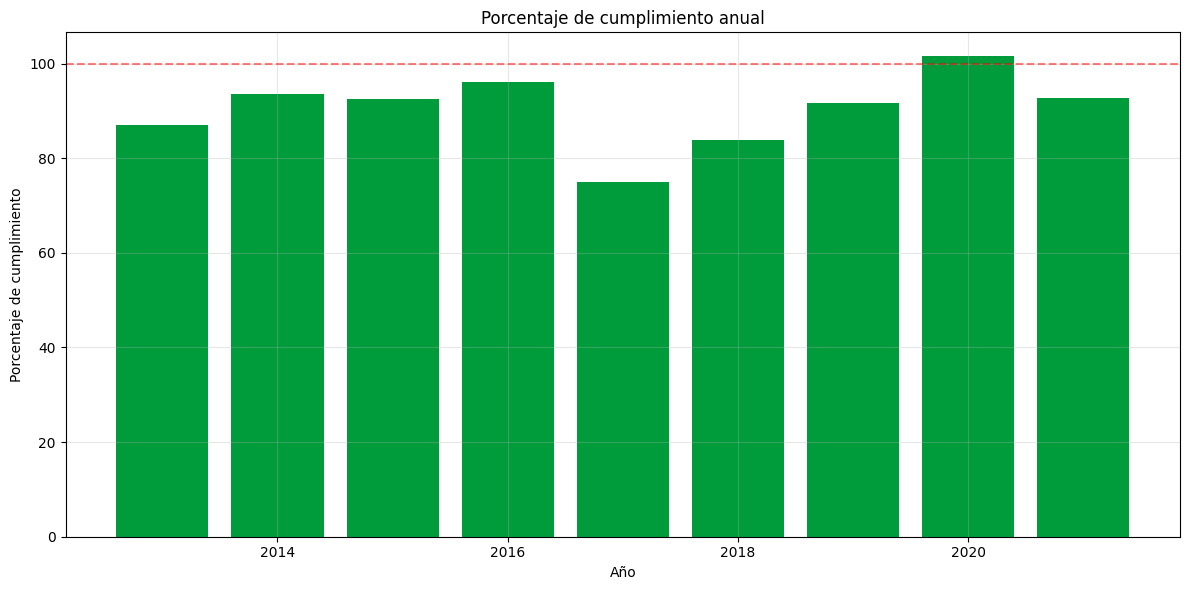

In [ ]:
# Usamos un gráfico de barras, tomando el 100% como referencia
plt.figure(figsize=(12, 6))
plt.bar(analisis_anual.index, analisis_anual['porcentaje_cumplimiento'],
        color='#009c3b')

plt.axhline(y=100, color='red', linestyle='--', alpha=0.5)
plt.title('Porcentaje de cumplimiento anual')
plt.xlabel('Año')
plt.ylabel('Porcentaje de cumplimiento')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5 Resumen fnal y conclusiones
## 5.1 Recomendaciones
- Revisar cómo se puede mejorar la previsión de valores recaudados.
- Analizar más profundamente el éxito de 2020 y la caida de 2017.
- Qué afecta a la volatilidad en operaciones intra-presupuestarias.

## 5.2 Conclusiones
- Sistema presupuestario generalmente efectivo, aunque algo optimista.
- Buena capacidad de recuperación tras períodos difíciles.